## Modulation Recognition Example: RML2016.10a Dataset + VT-CNN2 Mod-Rec Network

This work is copyright DeepSig Inc. 2017.
It is provided open source under the Create Commons Attribution-NonCommercial 4.0 International (CC BY-NC 4.0) Licence
https://creativecommons.org/licenses/by-nc/4.0/

Use of this work, or derivitives inspired by this work is permitted for non-commercial usage only and with explicit citaiton of this original work.

A more detailed description of this work can be found at
https://arxiv.org/abs/1602.04105

A more detailed description of the RML2016.10a dataset can be found at
http://pubs.gnuradio.org/index.php/grcon/article/view/11

Citation of this work is required in derivative works:

```
@article{convnetmodrec,
  title={Convolutional Radio Modulation Recognition Networks},
  author={O'Shea, Timothy J and Corgan, Johnathan and Clancy, T. Charles},
  journal={arXiv preprint arXiv:1602.04105},
  year={2016}
}
@article{rml_datasets,
  title={Radio Machine Learning Dataset Generation with GNU Radio},
  author={O'Shea, Timothy J and West, Nathan},
  journal={Proceedings of the 6th GNU Radio Conference},
  year={2016}
}
```

The RML2016.10a dataset is used for this work (https://radioml.com/datasets/)


In [1]:
# Import all the things we need ---
#   by setting env variables before Keras import you can set up which backend and which GPU it uses
%matplotlib inline
import os,random
os.environ["KERAS_BACKEND"] = "theano"
# os.environ["KERAS_BACKEND"] = "tensorflow"
# os.environ["THEANO_FLAGS"]  = "device=gpu%d"%(1)
os.environ["THEANO_FLAGS"]  = "device=cpu"
# os.environ["CUDA_VISIBLE_DEVICES"] = " "
import numpy as np
import theano as th
import theano.tensor as T
from keras.utils import np_utils
import keras.models as models
from keras.layers.core import Reshape,Dense,Dropout,Activation,Flatten
from keras.layers.noise import GaussianNoise
from keras.layers.convolutional import Convolution1D,Convolution2D, MaxPooling2D, ZeroPadding2D, Conv2D
from keras.regularizers import *
from keras.optimizers import adam
import matplotlib.pyplot as plt
# import seaborn as sns
import cPickle
import random, sys, keras
import time 

Using Theano backend.


# Dataset setup

In [2]:

# Load the dataset ...
#  You will need to seperately download or generate this file
Xd = cPickle.load(open("RML2016.10a_dict.pkl",'rb'))
# with open("RML2016.10a_dict.pkl",'rb') as f:
#     Xd = cPickle.load(f, encoding="latin1")

X = cPickle.load(open("pca_D_256.pkl", "rb"))
 
# print(Xd.shape) #Xd is a dictionary
snrs,mods = map(lambda j: sorted(list(set(map(lambda x: x[j], Xd.keys())))), [1,0])

# X = []  
lbl = []
for snr in snrs:
    for mod in mods:
#         X.append(Xd[(mod,snr)])
        for i in range(Xd[(mod,snr)].shape[0]):  lbl.append((mod,snr))
# print(X.shape)
# print(X)

# print(X.shape)
# print(X)

In [3]:
X = np.vstack(X)
np.shape(X)

(220000, 256)

In [4]:
np.shape(lbl)

(220000, 2)

In [5]:
# Partition the data
#  into training and test sets of the form we can train/test on 
#  while keeping SNR and Mod labels handy for each
np.random.seed(2016)
n_examples = X.shape[0] ##220000个examples
n_train = n_examples * 0.5 ##一半用来training
# n_train_int = int(n_examples * 0.5)

train_idx = np.random.choice(range(0,n_examples), size=int(n_train), replace=False) ## idx 随机抽取example作为training set，打乱顺序
test_idx = list(set(range(0,n_examples))-set(train_idx)) ## 剩下的idx对应的数据为test set

X_train = X[train_idx]
X_test =  X[test_idx]


# label the data with correponding mod by one_hot technique
def to_onehot(yy):
    # yy_l = list(yy)  ## map() in python 3 has has no attribute of len.
    yy1 = np.zeros([len(yy), max(yy)+1])
    yy1[np.arange(len(yy)),yy] = 1
    return yy1
Y_train = to_onehot(map(lambda x: mods.index(lbl[x][0]), train_idx))
Y_test = to_onehot(map(lambda x: mods.index(lbl[x][0]), test_idx))
# print(Y_train)(
# print(Y_train.shape) # (110000,11)

In [6]:
X_train

array([[ 4.82292019e+00,  1.82999777e+00,  2.40451895e+00, ...,
         8.43834027e-01, -1.69109607e+00, -1.09146467e+00],
       [-5.03484289e-01, -1.72628177e-01,  2.26185094e-01, ...,
         1.12181365e-01, -2.97424421e-01,  5.60730799e-01],
       [ 1.54701472e+00,  6.41868560e-01, -1.94924643e+00, ...,
        -6.59426478e-01, -7.33549723e-01, -3.07047205e-02],
       ...,
       [ 2.75727021e+00,  2.02177688e-01,  6.58671332e-01, ...,
         3.93492859e-01, -1.43959926e+00,  3.11858558e-01],
       [ 3.11570939e-02, -1.29922272e-01,  1.08948728e+00, ...,
        -9.86847434e-01,  1.94813417e-01, -8.92438766e-01],
       [-1.17359447e+00,  8.59860963e-01, -4.67227326e+00, ...,
         1.55340872e-02, -9.58642857e-03,  1.17016215e-04]])

In [7]:
np.shape(X_train)

(110000, 256)

In [8]:
## X.train contains the dataset to be used during training, in_sp represents the data format 
in_shp = list(X_train.shape[1:])
# in_shp = [1,256]
print X_train.shape, in_shp
classes = mods
print classes

print [1]+in_shp


(110000, 256) [256]
['8PSK', 'AM-DSB', 'AM-SSB', 'BPSK', 'CPFSK', 'GFSK', 'PAM4', 'QAM16', 'QAM64', 'QPSK', 'WBFM']
[1, 256]


# Build the NN Model

In [9]:

# Build VT-CNN2 Neural Net model using Keras primitives -- 
#  - Reshape [N,26] to [N,1,26] on input
#  - Pass through 2 2DConv/ReLu layers
#  - Pass through 2 Dense layers (ReLu and Softmax)
#  - Perform categorical cross entropy optimization

batch_size = 10
dr = 0.5 # dropout rate (%)
model = models.Sequential()
model.add(Reshape([1]+in_shp+[1], input_shape=in_shp))
# model.add(Convolution1D(128, 3, init='glorot_uniform',border_mode='same',input_shape = (2,128)))
model.add(ZeroPadding2D((0, 2)))
model.add(Convolution2D(256, 1, 3, border_mode='valid', activation="relu", name="conv1", init='glorot_uniform'))
model.add(Dropout(dr))
model.add(ZeroPadding2D((0, 2)))
model.add(Convolution2D(80, 1, 3, border_mode="valid", activation="relu", name="conv2", init='glorot_uniform'))
model.add(Dropout(dr))
model.add(Flatten())
model.add(Dense(256, activation='relu', init='he_normal', name="dense1"))
model.add(Dropout(dr))
model.add(Dense( len(classes), init='he_normal', name="dense2" ))
model.add(Activation('softmax'))
model.add(Reshape([len(classes)]))
model.compile(loss='categorical_crossentropy', optimizer='adam')
model.summary()


/Users/xuyangwang/anaconda3/envs/python2/lib/python2.7/site-packages/ipykernel_launcher.py:14: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(256, (1, 3), kernel_initializer="glorot_uniform", name="conv1", activation="relu", padding="valid")`
  
/Users/xuyangwang/anaconda3/envs/python2/lib/python2.7/site-packages/ipykernel_launcher.py:17: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(80, (1, 3), kernel_initializer="glorot_uniform", name="conv2", activation="relu", padding="valid")`
/Users/xuyangwang/anaconda3/envs/python2/lib/python2.7/site-packages/ipykernel_launcher.py:20: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(256, kernel_initializer="he_normal", activation="relu", name="dense1")`
/Users/xuyangwang/anaconda3/envs/python2/lib/python2.7/site-packages/ipykernel_launcher.py:22: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(11, kernel_initializer="he_normal", name="dense2")`


Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape_1 (Reshape)          (None, 1, 256, 1)         0         
_________________________________________________________________
zero_padding2d_1 (ZeroPaddin (None, 1, 260, 1)         0         
_________________________________________________________________
conv1 (Conv2D)               (None, 1, 258, 256)       1024      
_________________________________________________________________
dropout_1 (Dropout)          (None, 1, 258, 256)       0         
_________________________________________________________________
zero_padding2d_2 (ZeroPaddin (None, 1, 262, 256)       0         
_________________________________________________________________
conv2 (Conv2D)               (None, 1, 260, 80)        61520     
_________________________________________________________________
dropout_2 (Dropout)          (None, 1, 260, 80)       

In [10]:
# Set up some params 
nb_epoch = 100     # number of epochs to train on
batch_size = 1024  # training batch size

# Train the Model

In [11]:
# perform training ...
#   - call the main training loop in keras for our network+dataset
filepath = 'convmodrecnets_CNN2_0.5.wts.h5'
history = model.fit(X_train,
    Y_train,
    batch_size=batch_size,
    nb_epoch=nb_epoch,
#     show_accuracy=False,
    verbose=2,
    validation_data=(X_test, Y_test),
    callbacks = [
        keras.callbacks.ModelCheckpoint(filepath, monitor='val_loss', verbose=0, save_best_only=True, mode='auto'),
        keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, verbose=0, mode='auto')
    ])
# we re-load the best weights once training is finished
model.load_weights(filepath)

/Users/xuyangwang/anaconda3/envs/python2/lib/python2.7/site-packages/ipykernel_launcher.py:13: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  del sys.path[0]


Train on 110000 samples, validate on 110000 samples
Epoch 1/100
 - 789s - loss: 1.8578 - val_loss: 1.7332
Epoch 2/100
 - 792s - loss: 1.7173 - val_loss: 1.6448
Epoch 3/100
 - 846s - loss: 1.6528 - val_loss: 1.6322
Epoch 4/100
 - 793s - loss: 1.6122 - val_loss: 1.6079
Epoch 5/100
 - 777s - loss: 1.5768 - val_loss: 1.5409
Epoch 6/100
 - 18285s - loss: 1.5485 - val_loss: 1.5402
Epoch 7/100
 - 1167s - loss: 1.5197 - val_loss: 1.5624
Epoch 8/100
 - 770s - loss: 1.4912 - val_loss: 1.4976
Epoch 9/100
 - 787s - loss: 1.4650 - val_loss: 1.4957
Epoch 10/100
 - 832s - loss: 1.4395 - val_loss: 1.4940
Epoch 11/100
 - 817s - loss: 1.4145 - val_loss: 1.4865
Epoch 12/100
 - 820s - loss: 1.3896 - val_loss: 1.4913
Epoch 13/100
 - 777s - loss: 1.3599 - val_loss: 1.4796
Epoch 14/100
 - 771s - loss: 1.3425 - val_loss: 1.4939
Epoch 15/100
 - 766s - loss: 1.3199 - val_loss: 1.5064
Epoch 16/100
 - 784s - loss: 1.3005 - val_loss: 1.4864
Epoch 17/100
 - 799s - loss: 1.2843 - val_loss: 1.4991
Epoch 18/100
 - 769

# Evaluate and Plot Model Performance

In [12]:
# start_time = time.time()
# Show simple version of performance
score = model.evaluate(X_test, Y_test, verbose=0, batch_size=batch_size)
# score = model.evaluate(X_test, Y_test, show_accuracy=True, verbose=0, batch_size=batch_size)
# end_time = time.time()
# score_time = end_time - start_time
# print score_time
# print score

271.536356926
1.47961027343


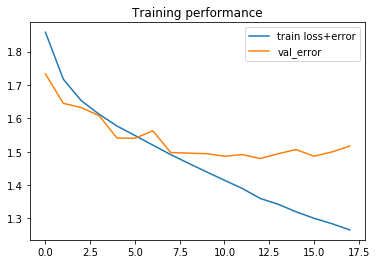

In [13]:
# Show loss curves 
plt.figure()
plt.title('Training performance')
plt.plot(history.epoch, history.history['loss'], label='train loss+error')
plt.plot(history.epoch, history.history['val_loss'], label='val_error')
plt.legend()

In [14]:
def plot_confusion_matrix(cm, title='Confusion matrix', cmap=plt.cm.Blues, labels=[]):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(labels))
    plt.xticks(tick_marks, labels, rotation=45)
    plt.yticks(tick_marks, labels)
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

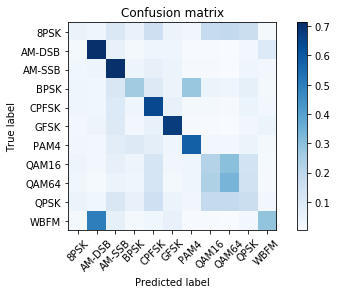

In [15]:
# Plot confusion matrix
test_Y_hat = model.predict(X_test, batch_size=batch_size)
conf = np.zeros([len(classes),len(classes)])
confnorm = np.zeros([len(classes),len(classes)])
for i in range(0,X_test.shape[0]):
    j = list(Y_test[i,:]).index(1)
    k = int(np.argmax(test_Y_hat[i,:]))
    conf[j,k] = conf[j,k] + 1
for i in range(0,len(classes)):
    confnorm[i,:] = conf[i,:] / np.sum(conf[i,:])
plot_confusion_matrix(confnorm, labels=classes)



Overall Accuracy:  0.09624413145539906
Overall Accuracy:  0.09996391194514616
Overall Accuracy:  0.10311355311355311
Overall Accuracy:  0.12476962771839292
Overall Accuracy:  0.1538882803943045
Overall Accuracy:  0.19002890173410406
Overall Accuracy:  0.2728438015015565
Overall Accuracy:  0.36960873521383075
Overall Accuracy:  0.45646583394562823
Overall Accuracy:  0.4904124457308249
Overall Accuracy:  0.5409836065573771
Overall Accuracy:  0.6158735924446059
Overall Accuracy:  0.647677793904209
Overall Accuracy:  0.6470269293330924
Overall Accuracy:  0.6432262827611664
Overall Accuracy:  0.6056925308194344
Overall Accuracy:  0.5989383122826286
Overall Accuracy:  0.5995674896377726
Overall Accuracy:  0.5824657534246576
Overall Accuracy:  0.5930728241563055


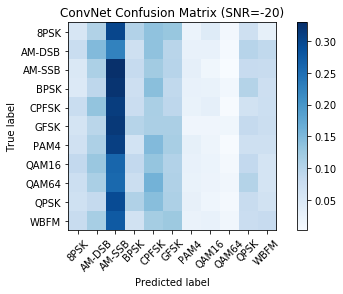

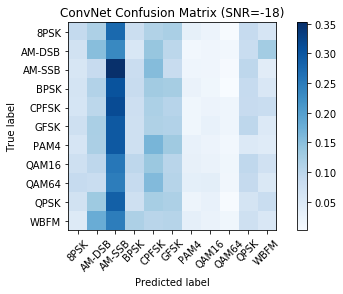

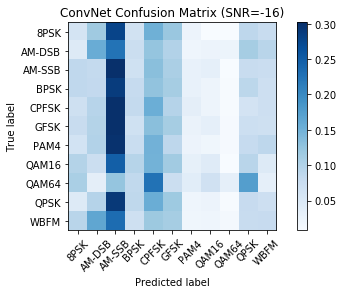

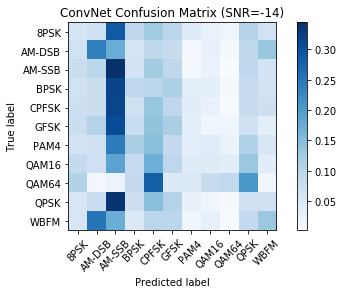

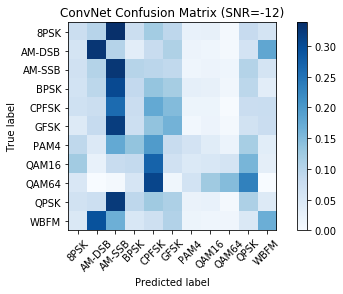

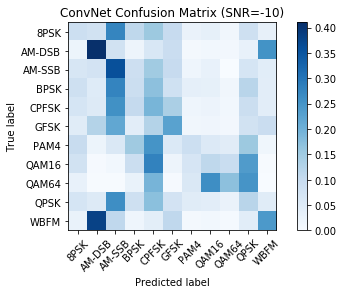

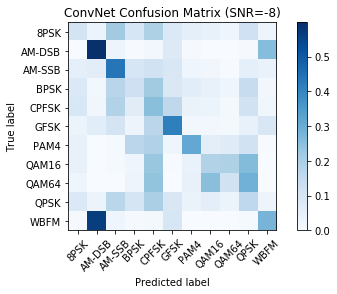

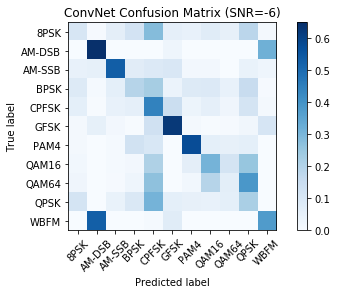

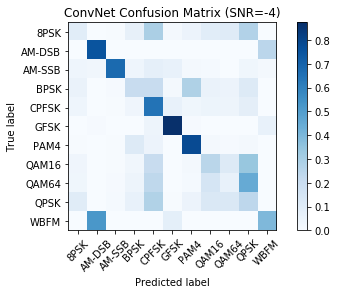

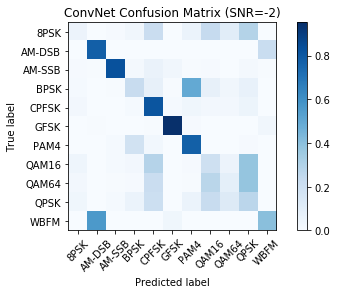

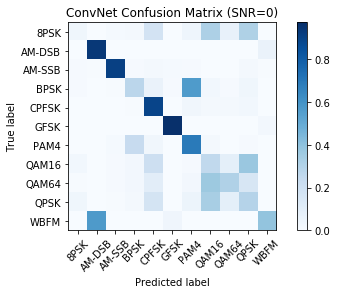

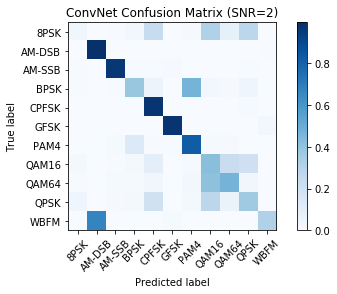

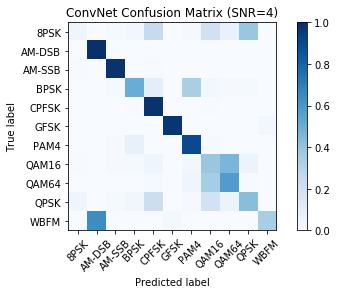

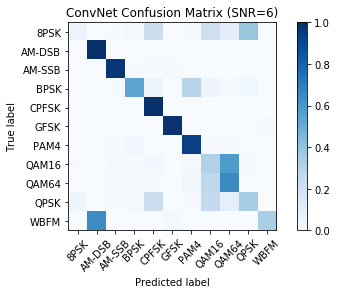

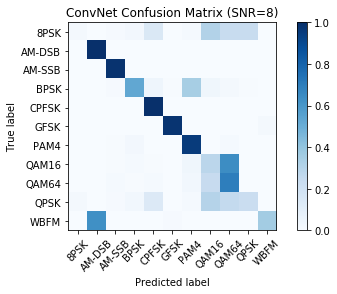

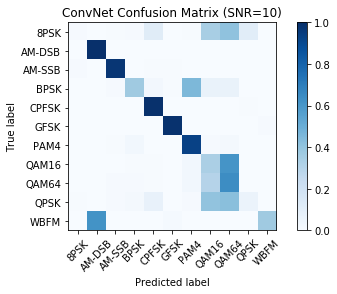

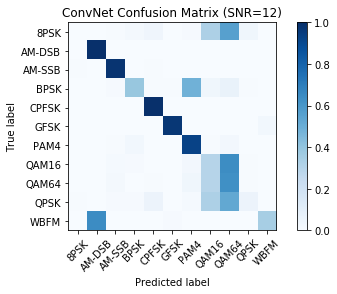

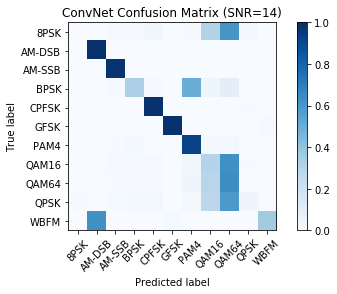

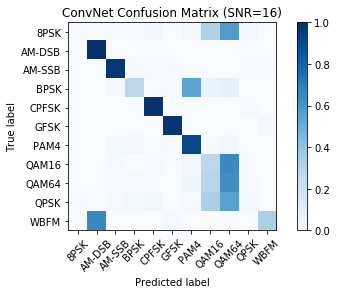

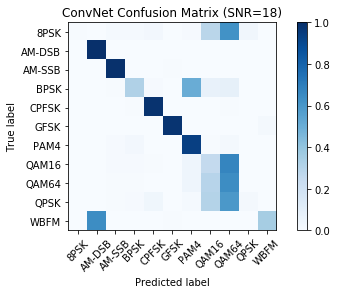

In [16]:
# Plot confusion matrix
acc = {}
for snr in snrs:

    # extract classes @ SNR
    test_SNRs = map(lambda x: lbl[x][1], test_idx)
    test_X_i = X_test[np.where(np.array(test_SNRs)==snr)]
    test_Y_i = Y_test[np.where(np.array(test_SNRs)==snr)]    

    # estimate classes
    test_Y_i_hat = model.predict(test_X_i)
    conf = np.zeros([len(classes),len(classes)])
    confnorm = np.zeros([len(classes),len(classes)])
    for i in range(0,test_X_i.shape[0]):
        j = list(test_Y_i[i,:]).index(1)
        k = int(np.argmax(test_Y_i_hat[i,:]))
        conf[j,k] = conf[j,k] + 1
    for i in range(0,len(classes)):
        confnorm[i,:] = conf[i,:] / np.sum(conf[i,:])
    plt.figure()
    plot_confusion_matrix(confnorm, labels=classes, title="ConvNet Confusion Matrix (SNR=%d)"%(snr))
    
    cor = np.sum(np.diag(conf))
    ncor = np.sum(conf) - cor
    print "Overall Accuracy: ", cor / (cor+ncor)
    acc[snr] = 1.0*cor/(cor+ncor)
    

In [17]:
# Save results to a pickle file for plotting later
print acc
fd = open('results_cnn2_d0.5.dat','wb')
cPickle.dump( ("CNN2", 0.5, acc) , fd )

{0: 0.5409836065573771, 16: 0.5824657534246576, 2: 0.6158735924446059, 4: 0.647677793904209, 6: 0.6470269293330924, 8: 0.6432262827611664, 12: 0.5989383122826286, 10: 0.6056925308194344, -20: 0.09624413145539906, 18: 0.5930728241563055, -18: 0.09996391194514616, -16: 0.10311355311355311, -14: 0.12476962771839292, -12: 0.1538882803943045, 14: 0.5995674896377726, -10: 0.19002890173410406, -8: 0.2728438015015565, -6: 0.36960873521383075, -4: 0.45646583394562823, -2: 0.4904124457308249}


Text(0.5,1,'CNN2 Classification Accuracy on RadioML 2016.10 Alpha')

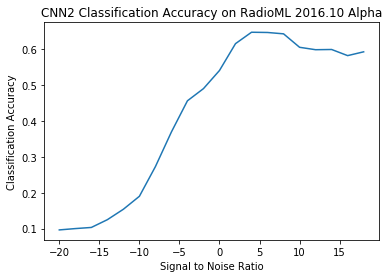

In [18]:
# Plot accuracy curve
plt.plot(snrs, map(lambda x: acc[x], snrs))
plt.xlabel("Signal to Noise Ratio")
plt.ylabel("Classification Accuracy")
plt.title("CNN2 Classification Accuracy on RadioML 2016.10 Alpha")